# 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, brier_score_loss
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from scipy.stats import ks_2samp, mannwhitneyu
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
SEED = 42
REPEATS = 5
FOLDS = 5

train_combined = pd.read_csv("train_processed.csv").set_index("participant_id")
test_combined = pd.read_csv("test_processed.csv").set_index("participant_id")

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

train_combined = train_combined.sort_index()
labels = labels.sort_index()
assert all(train_combined.index == labels.index), "Label IDs do not match train IDs"

In [3]:
train_combined

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Laterality_Category
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,...,9.0,14.274127,3,1.0,1,2,0,1,3,2
00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,...,8.0,14.254727,1,0.0,0,2,1,2,0,2
04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,...,7.0,13.463381,1,1.0,0,1,1,1,3,2
05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,...,6.0,9.572553,2,2.0,0,0,1,0,1,2
06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,...,4.0,6.654574,2,0.0,0,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zpU7rEseBMH8,100.00,14.0,3.0,11.0,41.0,16.0,23.0,24.0,0.0,8.0,...,8.0,12.669860,1,0.0,0,1,2,2,0,2
zpr8w4jCfVPe,100.00,14.0,3.0,9.0,41.0,22.0,10.0,29.0,1.0,15.0,...,7.0,9.174983,3,1.0,0,1,1,2,4,2
zwBG0rZ05Mcb,46.67,13.0,3.0,12.0,30.0,18.0,14.0,24.0,0.0,10.0,...,8.0,8.155258,0,0.0,1,1,3,0,4,1


# 2. Feature Selection

In [4]:
def add_new_features(df):
    epsilon = 1e-5
    df['I_Hyper_External'] = df['SDQ_SDQ_Hyperactivity'] * df['SDQ_SDQ_Externalizing']
    
    df['Diff_External_Internal'] = df['SDQ_SDQ_Externalizing'] - df['SDQ_SDQ_Internalizing']
    
    # Ratio: externalizing divided by internalizing (avoid division by zero)
    df['Ratio_External_Internal'] = df['SDQ_SDQ_Externalizing'] / (df['SDQ_SDQ_Internalizing'] + epsilon)
    
    # Composite score: average of hyperactivity, externalizing, and emotional problems
    df['Composite_SDQ'] = (df['SDQ_SDQ_Hyperactivity'] + 
                           df['SDQ_SDQ_Externalizing'] + 
                           df['SDQ_SDQ_Emotional_Problems']) / 3
    
    # Log transformation of composite score to reduce skewness
    df['Log_Composite_SDQ'] = np.log1p(df['Composite_SDQ'])
    
    # Domain knowledge based features
    if 'MRI_Track_Age_at_Scan' in df.columns:
        df['Age_Adjusted_Hyperactivity'] = df['SDQ_SDQ_Hyperactivity'] / (df['MRI_Track_Age_at_Scan'] + epsilon)
    
    if 'Basic_Demos_Enroll_Year' in df.columns:
        df['Relative_Enroll_Year'] = df['Basic_Demos_Enroll_Year'] - df['Basic_Demos_Enroll_Year'].min()
        df['Enroll_Year_Bin'] = pd.cut(df['Basic_Demos_Enroll_Year'], bins=3, labels=[1, 2, 3])
    
    if 'APQ_P_APQ_P_ID' in df.columns:
        df['Parent_Behavior_Interaction'] = df['APQ_P_APQ_P_ID'] * df['Composite_SDQ']
    return df

def eval_metrics(y_true, y_pred, weights, label="None", threshold=0.5):
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > threshold).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

In [5]:
# Apply the feature engineering function
train_combined = add_new_features(train_combined)
test_combined = add_new_features(test_combined)

In [6]:
scaler = StandardScaler()
train_combined = pd.DataFrame(scaler.fit_transform(train_combined), columns=train_combined.columns, index=train_combined.index)
test_combined = pd.DataFrame(scaler.transform(test_combined), columns=test_combined.columns, index=test_combined.index)

In [7]:
y_adhd = labels['ADHD_Outcome']
y_sex = labels['Sex_F']
combinations = y_adhd.astype(str) + y_sex.astype(str)

# Define features for ADHD prediction (including newly engineered features)
features_adhd = [
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Difficulties_Total', 
    'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Internalizing', 
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Prosocial', 
    'Basic_Demos_Enroll_Year', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_ID',
    #### New Features ####
    'I_Hyper_External', 'Diff_External_Internal', 'Ratio_External_Internal', 
    'Composite_SDQ', 'Log_Composite_SDQ', 'Enroll_Year_Bin', 'Relative_Enroll_Year',
    'Parent_Behavior_Interaction'
]
interactions = ['SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Peer_Problems', 'Basic_Demos_Enroll_Year', 'APQ_P_APQ_P_ID']

features_sex = [
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Prosocial', 'SDQ_SDQ_Externalizing', 
    'SDQ_SDQ_Emotional_Problems', 'ColorVision_CV_Score', 'APQ_P_APQ_P_PP', 
    'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'SDQ_SDQ_Internalizing', 'adhd_proba'
] + [f"I_{feat}" for feat in interactions] + ['Parent_Behavior_Interaction', 'Relative_Enroll_Year']

In [8]:
# y_adhd = labels['ADHD_Outcome']
# y_sex = labels['Sex_F']
# combinations = y_adhd.astype(str) + y_sex.astype(str)

# # Interaction terms (for ADHD-first -> then Sex model)
# interactions = [
#     "APQ_P_APQ_P_INV", "APQ_P_APQ_P_PP", "SDQ_SDQ_Hyperactivity", 
#     "MRI_Track_Age_at_Scan", "SDQ_SDQ_Generating_Impact", 'SDQ_SDQ_Emotional_Problems',
#     'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Conduct_Problems',
#     'SDQ_SDQ_Prosocial',
# ]

# # Features for the ADHD model (first stage)
# features_adhd = [
#     'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
#     'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
#     'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
#     'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
#     'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
#     'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
#     'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
#     'Basic_Demos_Enroll_Year', 'PreInt_Demos_Fam_Child_Ethnicity',
#     'PreInt_Demos_Fam_Child_Race', 'Barratt_Barratt_P1_Edu',
#     'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
#     'Barratt_Barratt_P2_Occ', 'Laterality_Category'
# ]

# # Features for the Sex model (second stage), note we use the ADHD probability and corresponding interactions
# features_sex = features_adhd + ['adhd_proba'] + [f"I_{feat}" for feat in interactions]

In [9]:
# Initialize out-of-fold arrays and scores
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))
scores_sex = []
scores_adhd = []

t_sex = 0.3
t_adhd = 0.4

rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS)

# Updated parameters including class_weight to balance the classes based on their distribution
params = {
    "penalty": "l1",
    "Cs": 10,
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga",
    "class_weight": "balanced"   # This tells the model to adjust weights inversely proportional to class frequencies
}

model_adhd = LogisticRegressionCV(**params)
model_sex  = LogisticRegressionCV(**params)

In [10]:
for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} ===")
    X_train, X_val = train_combined.iloc[train_idx].copy(), train_combined.iloc[val_idx].copy()
    y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]
    
    # Sample weights: 2x weight for "11" (female ADHD) cases, per competition requirements
    weights_train = np.where(combinations.iloc[train_idx] == "11", 2, 1)
    weights = np.where(combinations.iloc[val_idx] == "11", 2, 1)
    
    # ----- First Stage: ADHD Model -----
    model_adhd.fit(X_train[features_adhd], y_train_adhd, sample_weight=weights_train)
    adhd_train = model_adhd.predict_proba(X_train[features_adhd])[:, 1]
    adhd_val   = model_adhd.predict_proba(X_val[features_adhd])[:, 1]
    adhd_oof[val_idx] += adhd_val / REPEATS
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "ADHD", t_adhd)
    scores_adhd.append((adhd_brier, adhd_f1))
    
    # ----- Second Stage: Sex Model -----
    # Add ADHD probability and create interaction features on both training and validation sets
    X_train["adhd_proba"] = adhd_train
    X_val["adhd_proba"] = adhd_val
    for feat in interactions:
        X_train[f"I_{feat}"] = X_train[feat] * X_train["adhd_proba"]
        X_val[f"I_{feat}"] = X_val[feat] * X_val["adhd_proba"]

    model_sex.fit(X_train[features_sex], y_train_sex, sample_weight=weights_train)
    sex_val = model_sex.predict_proba(X_val[features_sex])[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS
    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F", t_sex)
    scores_sex.append((sex_brier, sex_f1))


=== Fold 1 ===
ADHD -> Brier Score: 0.1740, F1: 0.8820
Sex_F -> Brier Score: 0.2842, F1: 0.6274

=== Fold 2 ===
ADHD -> Brier Score: 0.1796, F1: 0.8613
Sex_F -> Brier Score: 0.3189, F1: 0.6276

=== Fold 3 ===
ADHD -> Brier Score: 0.1718, F1: 0.8750
Sex_F -> Brier Score: 0.2775, F1: 0.6274

=== Fold 4 ===
ADHD -> Brier Score: 0.1709, F1: 0.8825
Sex_F -> Brier Score: 0.2861, F1: 0.6238

=== Fold 5 ===
ADHD -> Brier Score: 0.1685, F1: 0.8950
Sex_F -> Brier Score: 0.3077, F1: 0.6259

=== Fold 6 ===
ADHD -> Brier Score: 0.1722, F1: 0.8871
Sex_F -> Brier Score: 0.2803, F1: 0.6253

=== Fold 7 ===
ADHD -> Brier Score: 0.1675, F1: 0.8870
Sex_F -> Brier Score: 0.2858, F1: 0.6291

=== Fold 8 ===
ADHD -> Brier Score: 0.1721, F1: 0.8815
Sex_F -> Brier Score: 0.2955, F1: 0.6244

=== Fold 9 ===
ADHD -> Brier Score: 0.1744, F1: 0.8810
Sex_F -> Brier Score: 0.2866, F1: 0.6288

=== Fold 10 ===
ADHD -> Brier Score: 0.1803, F1: 0.8619
Sex_F -> Brier Score: 0.2812, F1: 0.6288

=== Fold 11 ===
ADHD -> Brie

In [11]:
print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f}")


=== CV Results ===
Sex Mean Brier Score: 0.2874
Sex Mean F1: 0.6277
ADHD Mean Brier Score: 0.1731
ADHD Mean F1: 0.8797


# 3. Threshold Optimization

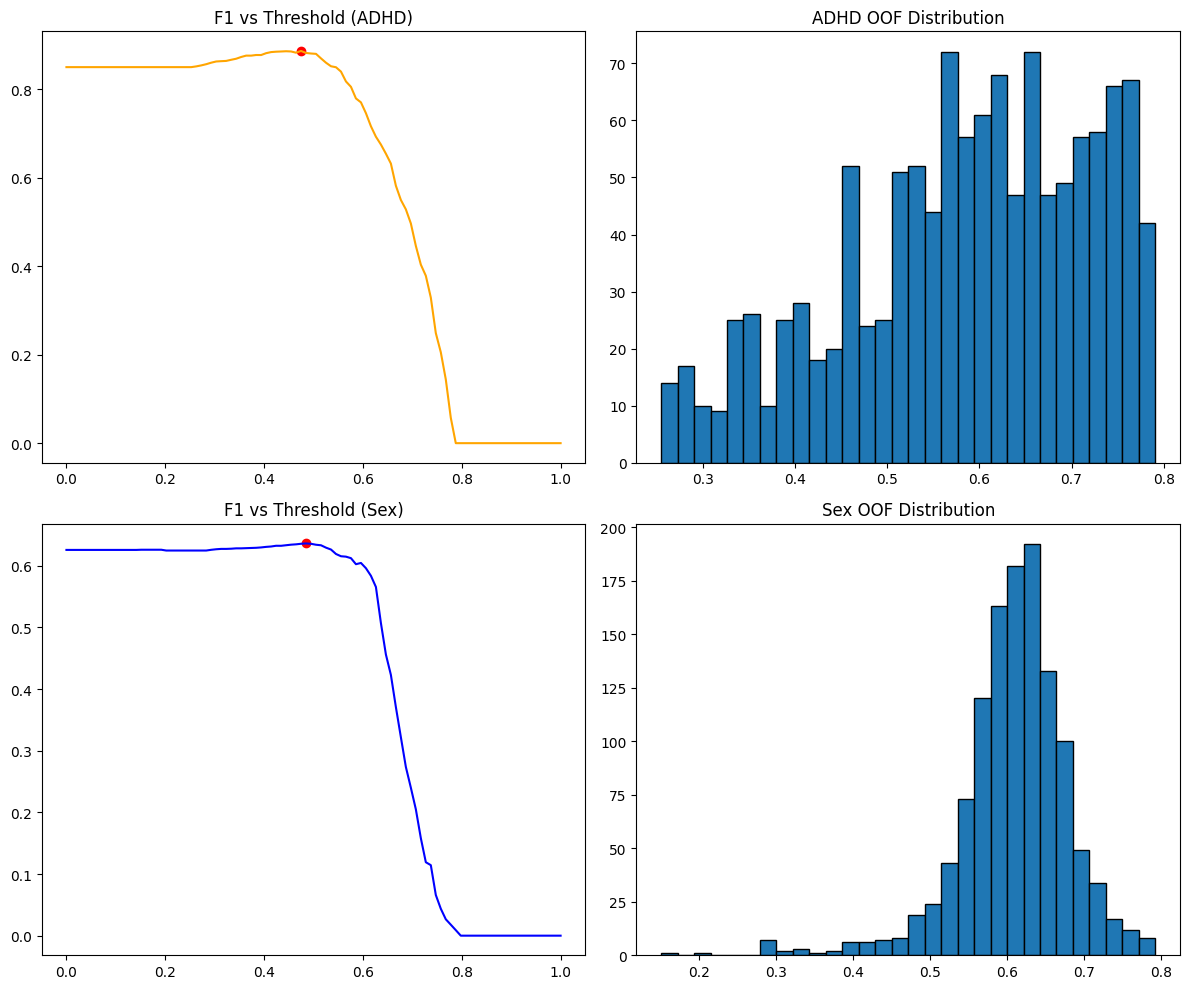

In [12]:
weights = ((y_adhd == 1) & (y_sex == 1)) + 1
thresholds = np.linspace(0, 1, 100)

# ADHD threshold optimization
adhd_scores = [f1_score(y_adhd, (adhd_oof > t).astype(int), sample_weight=weights) for t in thresholds]
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
best_adhd_score = max(adhd_scores)

# Sex threshold optimization
sex_scores = [f1_score(y_sex, (sex_oof > t).astype(int), sample_weight=weights) for t in thresholds]
best_sex_threshold = thresholds[np.argmax(sex_scores)]
best_sex_score = max(sex_scores)

# Plot the threshold analyses and score distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(thresholds, adhd_scores, color='orange')
axs[0, 0].scatter(best_adhd_threshold, best_adhd_score, color='red')
axs[0, 0].set_title('F1 vs Threshold (ADHD)')
axs[0, 1].hist(adhd_oof, bins=30, edgecolor='black')
axs[0, 1].set_title('ADHD OOF Distribution')
axs[1, 0].plot(thresholds, sex_scores, color='blue')
axs[1, 0].scatter(best_sex_threshold, best_sex_score, color='red')
axs[1, 0].set_title('F1 vs Threshold (Sex)')
axs[1, 1].hist(sex_oof, bins=30, edgecolor='black')
axs[1, 1].set_title('Sex OOF Distribution')
plt.tight_layout()
plt.show()

# 4. Inference

In [13]:
# ----- Final ADHD Model on full data -----
model_adhd.fit(train_combined[features_adhd], y_adhd, sample_weight=weights)
adhd_proba_train = model_adhd.predict_proba(train_combined[features_adhd])[:, 1]
adhd_proba_test = model_adhd.predict_proba(test_combined[features_adhd])[:, 1]

# Append ADHD predictions and interaction features for the Sex model
train_combined["adhd_proba"] = adhd_proba_train
test_combined["adhd_proba"] = adhd_proba_test

for feat in interactions:
    train_combined[f"I_{feat}"] = train_combined["adhd_proba"] * train_combined[feat]
    test_combined[f"I_{feat}"] = test_combined["adhd_proba"] * test_combined[feat]

# ----- Final Sex Model on full data -----
model_sex.fit(train_combined[features_sex], y_sex, sample_weight=weights)
sex_proba_test = model_sex.predict_proba(test_combined[features_sex])[:, 1]


In [14]:
# # Display the top 15 most influential features for the ADHD model:
# coeffs = pd.DataFrame({"feature": features_adhd, "coeff": model_adhd.coef_[0]})
# print(coeffs.sort_values(by="coeff", key=np.abs, ascending=False).head(15))

# # Perform distribution comparison tests between out-of-fold predictions and test probabilities
# print("KS and Mann-Whitney U Tests:")
# print("ADHD KS:", ks_2samp(adhd_proba_test, adhd_oof))
# print("ADHD MWU:", mannwhitneyu(adhd_proba_test, adhd_oof))
# print("Sex KS:", ks_2samp(sex_proba_test, sex_oof))
# print("Sex MWU:", mannwhitneyu(sex_proba_test, sex_oof))

In [15]:
# Submission
submission = pd.read_excel("data/SAMPLE_SUBMISSION.xlsx")
submission["ADHD_Outcome"] = np.where(adhd_proba_test > best_adhd_threshold, 1, 0)
submission["Sex_F"] = np.where(sex_proba_test > best_sex_threshold, 1, 0)
# Compare share of predicted labels at thresholds between OOF and Test
print(f"Share ADHD OOF: {np.mean(np.where(adhd_oof > best_adhd_threshold, 1, 0)):.4f} - Share ADHD Test: {submission.ADHD_Outcome.mean():.4f}")
print(f"Share Sex_F OOF: {np.mean(np.where(sex_oof > best_sex_threshold, 1, 0)):.4f} - Share Sex_F Test: {submission.Sex_F.mean():.4f}")

Share ADHD OOF: 0.7832 - Share ADHD Test: 0.7993
Share Sex_F OOF: 0.9571 - Share Sex_F Test: 0.9013


In [16]:
submission.to_csv("submission.csv", index=False)